In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
sys.path.append('..')

from utils import metrics
import evaluation

### Load data

In [2]:
def get_last_N(series, N=18):
    """
    Get the last N points in a timeseries. If len(ts) < N, pad the difference with the first value.

    :param series: A timeseries
    :param N: Number of points to keep
    :return: A timeseries of length N
    """
    ser_N = series.dropna().iloc[-N:].values
    if len(ser_N) < N:
        pad = [ser_N[0]] * (N - len(ser_N))
        ser_N = np.r_[pad, ser_N]
    return ser_N

In [3]:
train_path = '../data/Yearly-train.csv'
test_path = '../data/Yearly-test.csv'

train_set = pd.read_csv(train_path).drop('V1', axis=1)
test_set = pd.read_csv(test_path).drop('V1', axis=1)

X_test = np.array([get_last_N(ser[1], N=18) for ser in train_set.iterrows()])
y_test = test_set.values


In [4]:
X_test.shape, y_test.shape

((23000, 18), (23000, 6))

### Load model

In [5]:
models = '../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/'

In [6]:
model7 = tf.keras.models.load_model(models + 'weights_epoch_007.h5')

In [7]:
model7.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 18, 256)           133120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 18, 512)           1050624   
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 1536)              14157312  
_________________________________________________________________
reshape (Reshape)            (None, 6, 256)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 6, 1)             

### Generate predictions

In [8]:
preds = []

for x in tqdm(X_test):
    x = x.reshape(1, -1)
    mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1)
    x_sc = (x - mn) / (mx - mn)
    pred = model7(x_sc[..., np.newaxis])
    preds.append(pred[..., 0] * (mx - mn) + mn)

100%|██████████| 23000/23000 [22:24<00:00, 17.11it/s]


In [9]:
preds = np.array(preds)[:, 0, :]

In [10]:
preds.shape

(23000, 6)

In [11]:
inds = np.random.randint(len(X_test), size=16)

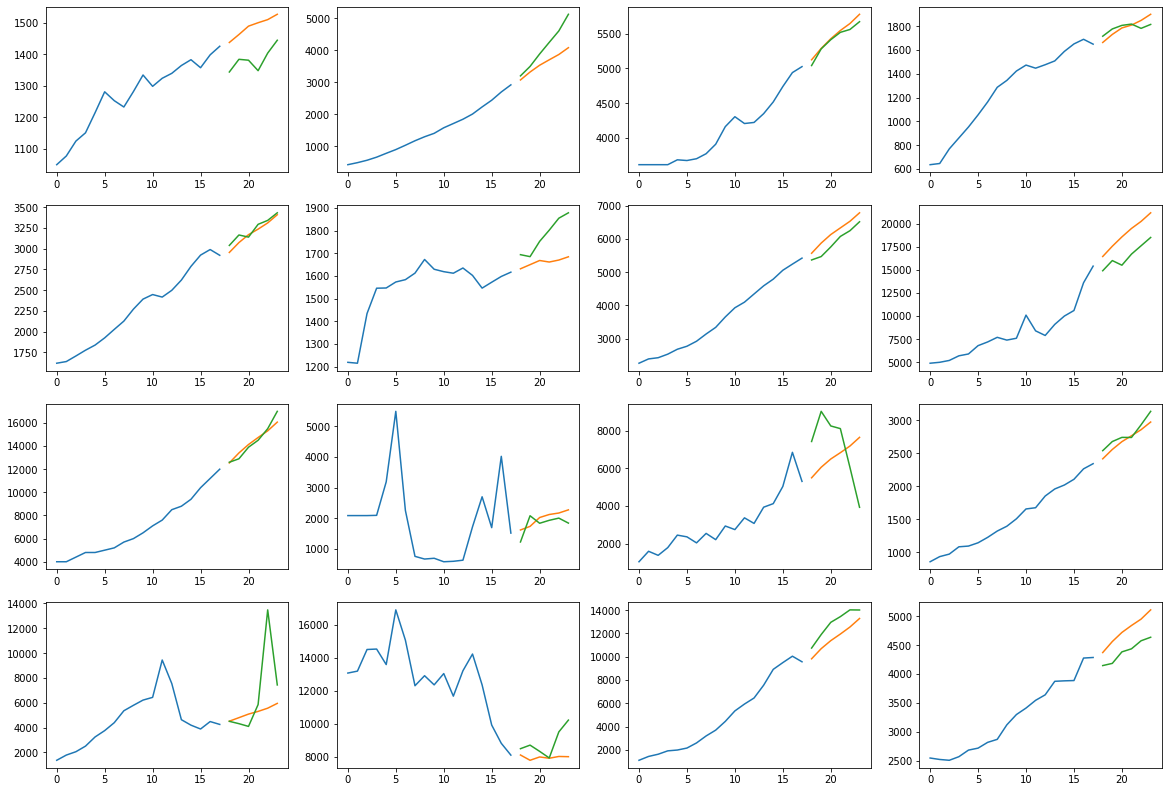

In [12]:
plt.figure(figsize=(20, 14))

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    ax.plot(range(18), X_test[inds[i]])
    ax.plot(range(18, 24), preds[inds[i]])
    ax.plot(range(18, 24), y_test[inds[i]])

In [13]:
metrics.SMAPE(y_test, preds).mean()

13.32386220031002

### Test all models

In [14]:
model_paths = [models + 'weights_epoch_{:03d}.h5'.format(e) for e in range(15)]

In [25]:
model_preds = {}

for i, m in enumerate(model_paths):
    
    model = tf.keras.models.load_model(m)
    preds = []

    for x in tqdm(X_test, desc='model {}'.format(i)):
        x = x.reshape(1, -1)
        mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1)
        x_sc = (x - mn) / (mx - mn)
        pred = model(x_sc[..., np.newaxis])
        preds.append(pred[..., 0] * (mx - mn) + mn)
        
    model_preds[m] = np.array(preds)[:, 0, :]

model 14: 100%|██████████| 23000/23000 [16:55<00:00, 22.65it/s]


In [28]:
with open('/tmp/analytical_preds.pkl', 'wb') as f:
    pkl.dump(model_preds, f)

In [9]:
with open('/tmp/analytical_preds.pkl', 'rb') as f:
    model_preds = pkl.load(f)

In [6]:
m = model_preds['../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_000.h5']

NameError: name 'model_preds' is not defined

weights_epoch_000.h5   13.967
weights_epoch_001.h5   13.697
weights_epoch_002.h5   13.498
weights_epoch_003.h5   13.307
weights_epoch_004.h5   13.505
weights_epoch_005.h5   13.283
weights_epoch_006.h5   13.289
weights_epoch_007.h5   13.324
weights_epoch_008.h5   13.285
weights_epoch_009.h5   13.374
weights_epoch_010.h5   13.378
weights_epoch_011.h5   13.333
weights_epoch_012.h5   13.259
weights_epoch_013.h5   13.243
weights_epoch_014.h5   13.321


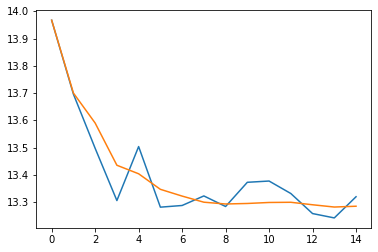

In [36]:
single = []
ensemble = []

agg = []

for k, v in model_preds.items():
    agg.append(v)
    s1 = metrics.SMAPE(y_test, v).mean()
    s2 = metrics.SMAPE(y_test, np.median(agg, axis=0)).mean()
    print('{}   {:.3f}'.format(k.split('/')[-1], s1))
    single.append(s1)
    ensemble.append(s2)
    
plt.plot(single)
plt.plot(ensemble)

### Investigate `get_predictions`

In [40]:
from evaluation import get_predictions

In [41]:
model_preds_2 = {}
for m in tqdm(model_paths):
    
    model = tf.keras.models.load_model(m)
    
    preds = get_predictions(model, X_test)
    
    model_preds_2[m] = preds

100%|██████████| 15/15 [05:52<00:00, 23.52s/it]


In [42]:
with open('/tmp/analytical_preds_2.pkl', 'wb') as f:
    pkl.dump(model_preds_2, f)

In [10]:
with open('/tmp/analytical_preds_2.pkl', 'rb') as f:
    model_preds_2 = pkl.load(f)

weights_epoch_000.h5   13.967
weights_epoch_001.h5   13.697
weights_epoch_002.h5   13.498
weights_epoch_003.h5   13.307
weights_epoch_004.h5   13.505
weights_epoch_005.h5   13.283
weights_epoch_006.h5   13.289
weights_epoch_007.h5   13.324
weights_epoch_008.h5   13.285
weights_epoch_009.h5   13.374
weights_epoch_010.h5   13.378
weights_epoch_011.h5   13.333
weights_epoch_012.h5   13.259
weights_epoch_013.h5   13.243
weights_epoch_014.h5   13.321


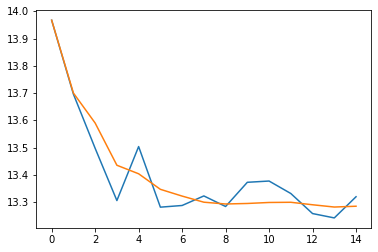

In [14]:
single_2 = []
ensemble_2 = []

agg_2 = []

for k, v in model_preds.items():
    agg_2.append(v)
    s1 = metrics.SMAPE(y_test, v).mean()
    s2 = metrics.SMAPE(y_test, np.median(agg_2, axis=0)).mean()
    print('{}   {:.3f}'.format(k.split('/')[-1], s1))
    single_2.append(s1)
    ensemble_2.append(s2)
    
plt.plot(single_2)
plt.plot(ensemble_2)

### Investigate `evaluate_family_with_multiple_weights`

In [21]:
all_model_preds_in_trial = []
results = {'smape': {}, 'mase*': {}}
epoch_ind = 0

for k, v in model_preds_2.items():

    preds = v

    all_model_preds_in_trial.append(preds)

    results['smape']['n' + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y_test, preds[:, -6:]))
    results['mase*']['n' + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(X_test, y_test, preds[:, -6:]))

    ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

    results['smape']['ens__' + 'n' + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y_test, ensemble_preds[:, -6:]))
    results['mase*']['ens__' + 'n' + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(X_test, y_test, ensemble_preds[:, -6:]))

    epoch_ind += 1
    
    print(epoch_ind)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [24]:
r1 = [v for k, v in results['smape'].items() if 'ens' not in k]
r2 = [v for k, v in results['smape'].items() if 'ens' in k]

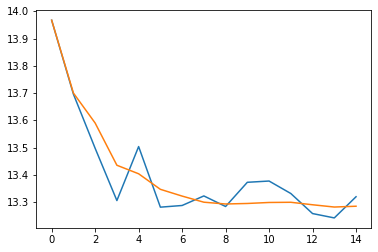

In [27]:
plt.plot(r1)
plt.plot(r2)

In [31]:
family = '../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True'

In [32]:
res = evaluation.evaluate_family_with_multiple_weights(family, X_test, y_test, result_dict=None, desc=None, verbose=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Run name: opt_adam__lr_0.001__ams_True__decay_True
Family path: ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True
Trials identified: 4
   0. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1
   1. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2
   2. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
   3. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3


100%|██████████| 4/4 [05:17<00:00, 79.49s/it]


In [34]:
subset = {k: v for k, v in res['smape'].items() if 'opt_adam__lr_0.001__ams_True__decay_True__0' in k}

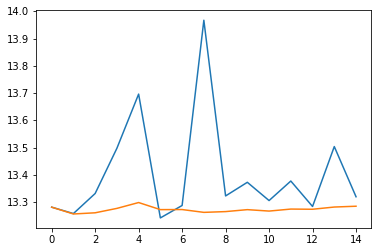

In [36]:
r1 = [v for k, v in subset.items() if 'ens' not in k]
r2 = [v for k, v in subset.items() if 'ens' in k]
plt.plot(r1)
plt.plot(r2)

In [41]:
res['smape'].keys()

dict_keys(['opt_adam__lr_0.001__ams_True__decay_True__1__epoch_1', 'ens__opt_adam__lr_0.001__ams_True__decay_True__1__epoch_1', 'opt_adam__lr_0.001__ams_True__decay_True__1__epoch_2', 'ens__opt_adam__lr_0.001__ams_True__decay_True__1__epoch_2', 'opt_adam__lr_0.001__ams_True__decay_True__1__epoch_3', 'ens__opt_adam__lr_0.001__ams_True__decay_True__1__epoch_3', 'opt_adam__lr_0.001__ams_True__decay_True__1__epoch_4', 'ens__opt_adam__lr_0.001__ams_True__decay_True__1__epoch_4', 'opt_adam__lr_0.001__ams_True__decay_True__1__epoch_5', 'ens__opt_adam__lr_0.001__ams_True__decay_True__1__epoch_5', 'opt_adam__lr_0.001__ams_True__decay_True__1__epoch_6', 'ens__opt_adam__lr_0.001__ams_True__decay_True__1__epoch_6', 'opt_adam__lr_0.001__ams_True__decay_True__1__epoch_7', 'ens__opt_adam__lr_0.001__ams_True__decay_True__1__epoch_7', 'opt_adam__lr_0.001__ams_True__decay_True__1__epoch_8', 'ens__opt_adam__lr_0.001__ams_True__decay_True__1__epoch_8', 'opt_adam__lr_0.001__ams_True__decay_True__1__epoch_9

In [46]:
def evaluate_family_1(family, x, y, result_dict=None, desc=None, verbose=False):

    if not result_dict:
        results = {'smape': {}, 'mase*': {}}
        results2 = {'smape': {}, 'mase*': {}}
    else:
        results = result_dict.copy()

    family = Path(family)
    trials = list(family.parent.glob(family.name + '*'))  # list for tqdm

    family_preds = None
    trial_ind = 0

    if verbose:
        print('Run name:', family.name)
        print('Family path:', str(family))
        print('Trials identified:', len(trials))
        for i, t in enumerate(trials):
            print('  {:>2d}. {}'.format(i, t))

    ensemble_preds_all_trials = []

    for trial in tqdm(trials, desc=desc):

        all_model_preds_in_trial = []

        trial = Path(trial)
        all_models_in_trial = list(trial.glob('*'))

        for epoch_ind, single_model in enumerate(all_models_in_trial):

            model = tf.keras.models.load_model(single_model)

            preds = get_predictions(model, x)

            if not family_preds:
                family_preds = [[] for _ in range(len(all_models_in_trial))]

            family_preds[epoch_ind].append(preds)
            all_model_preds_in_trial.append(preds)

            tf.keras.backend.clear_session()

            results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
            results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

            ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

            results['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
            results['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))

        trial_ind += 1

        ensemble_preds_all_trials.append(ensemble_preds)

    for i, epoch_preds in enumerate(family_preds):

        preds = np.median(np.array(epoch_preds), axis=0)

        results2['smape']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results2['mase*']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

    final_preds = np.median(np.array(ensemble_preds_all_trials), axis=0)

    results2['smape']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.SMAPE(y, final_preds[:, -6:]))
    results2['mase*']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.MASE(x, y, final_preds[:, -6:]))

    return results

In [47]:
res1, res2 = evaluate_family_1(family, X_test, y_test, verbose=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Run name: opt_adam__lr_0.001__ams_True__decay_True
Family path: ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True
Trials identified: 4
   0. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1
   1. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2
   2. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
   3. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3


100%|██████████| 4/4 [02:21<00:00, 35.39s/it]


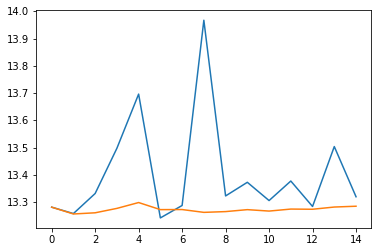

In [50]:
subset = {k: v for k, v in res1['smape'].items() if 'opt_adam__lr_0.001__ams_True__decay_True__0' in k}
r1 = [v for k, v in subset.items() if 'ens' not in k]
r2 = [v for k, v in subset.items() if 'ens' in k]
plt.plot(r1)
plt.plot(r2)

In [52]:
def evaluate_family_2(family, x, y, result_dict=None, desc=None, verbose=False):

    results = {'smape': {}, 'mase*': {}}
    results2 = {'smape': {}, 'mase*': {}} 

    family = Path(family)
    trials = list(family.parent.glob(family.name + '*'))  # list for tqdm

    family_preds = None
    trial_ind = 0

    if verbose:
        print('Run name:', family.name)
        print('Family path:', str(family))
        print('Trials identified:', len(trials))
        for i, t in enumerate(trials):
            print('  {:>2d}. {}'.format(i, t))

    ensemble_preds_all_trials = []

    for trial in trials:

        all_model_preds_in_trial = []

        trial = Path(trial)
        all_models_in_trial = list(trial.glob('*'))

        for epoch_ind, single_model in enumerate(all_models_in_trial):

            model = tf.keras.models.load_model(single_model)

            preds = evaluation.get_predictions(model, x)

            if not family_preds:
                family_preds = [[] for _ in range(len(all_models_in_trial))]

            family_preds[epoch_ind].append(preds)
            all_model_preds_in_trial.append(preds)

            tf.keras.backend.clear_session()

            results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
            results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

            ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

            results3['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
            results3['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))

            print('trial_ind', trial_ind)
            print('epoch_ind', epoch_ind)
            print('len(family_preds[epoch_ind])', len(family_preds[epoch_ind]))
            print('len(all_model_preds_in_trial)', len(all_model_preds_in_trial))
            print('len(results[smape])', len(results['smape']))
            
        trial_ind += 1

        ensemble_preds_all_trials.append(ensemble_preds)

    for i, epoch_preds in enumerate(family_preds):

        preds = np.median(np.array(epoch_preds), axis=0)

        results2['smape']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results2['mase*']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

    final_preds = np.median(np.array(ensemble_preds_all_trials), axis=0)

    results2['smape']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.SMAPE(y, final_preds[:, -6:]))
    results2['mase*']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.MASE(x, y, final_preds[:, -6:]))

    return results, results2

In [54]:
res1, res2 = evaluate_family_2(family, X_test, y_test, verbose=True)

Run name: opt_adam__lr_0.001__ams_True__decay_True
Family path: ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True
Trials identified: 4
   0. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1
   1. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2
   2. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
   3. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3
trial_ind 0
epoch_ind 0
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 1
len(results[smape]) 2
trial_ind 0
epoch_ind 1
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 2
len(results[smape]) 4
trial_ind 0
epoch_ind 2
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 3
len(results[smape]) 6
trial_ind 0
epoch_ind 3
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 4
len(results[smape]) 8
trial_ind 0
epoch_ind 4
len(family_preds[epoch_ind]) 1
len

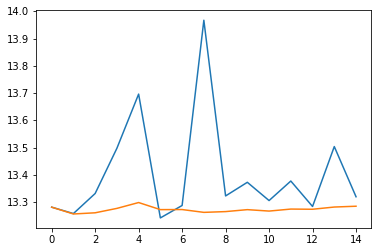

In [56]:
subset = {k: v for k, v in res1['smape'].items() if 'opt_adam__lr_0.001__ams_True__decay_True__0' in k}
r1 = [v for k, v in subset.items() if 'ens' not in k]
r2 = [v for k, v in subset.items() if 'ens' in k]
plt.plot(r1)
plt.plot(r2)

In [57]:
def evaluate_family_3(family, x, y, result_dict=None, desc=None, verbose=False):

    results = {'smape': {}, 'mase*': {}}
    results2 = {'smape': {}, 'mase*': {}} 
    results3 = {'smape': {}, 'mase*': {}} 

    family = Path(family)
    trials = list(family.parent.glob(family.name + '*'))  # list for tqdm

    family_preds = None
    trial_ind = 0

    if verbose:
        print('Run name:', family.name)
        print('Family path:', str(family))
        print('Trials identified:', len(trials))
        for i, t in enumerate(trials):
            print('  {:>2d}. {}'.format(i, t))

    ensemble_preds_all_trials = []

    for trial in trials:

        all_model_preds_in_trial = []

        trial = Path(trial)
        all_models_in_trial = list(trial.glob('*'))

        for epoch_ind, single_model in enumerate(all_models_in_trial):

            model = tf.keras.models.load_model(single_model)

            preds = evaluation.get_predictions(model, x)

            if not family_preds:
                family_preds = [[] for _ in range(len(all_models_in_trial))]

            family_preds[epoch_ind].append(preds)
            all_model_preds_in_trial.append(preds)

            tf.keras.backend.clear_session()

            results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
            results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

            ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

            results3['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
            results3['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))

            print('trial_ind', trial_ind)
            print('epoch_ind', epoch_ind)
            print('len(family_preds[epoch_ind])', len(family_preds[epoch_ind]))
            print('len(all_model_preds_in_trial)', len(all_model_preds_in_trial))
            print('len(results[smape])', len(results['smape']))
            
        trial_ind += 1

        ensemble_preds_all_trials.append(ensemble_preds)

    for i, epoch_preds in enumerate(family_preds):

        preds = np.median(np.array(epoch_preds), axis=0)

        results2['smape']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results2['mase*']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

    final_preds = np.median(np.array(ensemble_preds_all_trials), axis=0)

    results2['smape']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.SMAPE(y, final_preds[:, -6:]))
    results2['mase*']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.MASE(x, y, final_preds[:, -6:]))

    return results, results2, results3

In [58]:
res1, res2, res3 = evaluate_family_3(family, X_test, y_test, verbose=True)

Run name: opt_adam__lr_0.001__ams_True__decay_True
Family path: ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True
Trials identified: 4
   0. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1
   1. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2
   2. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
   3. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3
trial_ind 0
epoch_ind 0
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 1
len(results[smape]) 1
trial_ind 0
epoch_ind 1
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 2
len(results[smape]) 2
trial_ind 0
epoch_ind 2
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 3
len(results[smape]) 3
trial_ind 0
epoch_ind 3
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 4
len(results[smape]) 4
trial_ind 0
epoch_ind 4
len(family_preds[epoch_ind]) 1
len

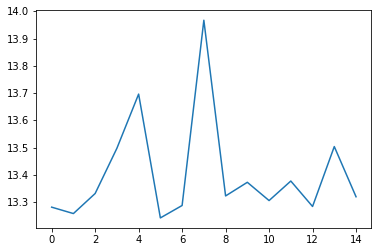

In [59]:
subset = {k: v for k, v in res1['smape'].items() if 'opt_adam__lr_0.001__ams_True__decay_True__0' in k}
r1 = [v for k, v in subset.items() if 'ens' not in k]
plt.plot(r1)

In [60]:
def evaluate_family_4(family, x, y, result_dict=None, desc=None, verbose=False):

    results = {'smape': {}, 'mase*': {}}
    results2 = {'smape': {}, 'mase*': {}} 
    results3 = {'smape': {}, 'mase*': {}} 

    family = Path(family)
    trials = list(family.parent.glob(family.name + '*'))  # list for tqdm

    family_preds = None
    trial_ind = 0

    if verbose:
        print('Run name:', family.name)
        print('Family path:', str(family))
        print('Trials identified:', len(trials))
        for i, t in enumerate(trials):
            print('  {:>2d}. {}'.format(i, t))

    ensemble_preds_all_trials = []

    for trial in trials:

        all_model_preds_in_trial = []

        trial = Path(trial)
        all_models_in_trial = list(trial.glob('*'))

        for epoch_ind, single_model in enumerate(all_models_in_trial):

            model = tf.keras.models.load_model(single_model)

            preds = evaluation.get_predictions(model, x)

            if not family_preds:
                family_preds = [[] for _ in range(len(all_models_in_trial))]

            family_preds[epoch_ind].append(preds)
            all_model_preds_in_trial.append(preds)

            tf.keras.backend.clear_session()

            results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
            results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

            ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

            results3['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
            results3['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))

            print('trial_ind', trial_ind)
            print('epoch_ind', epoch_ind)
            print('len(family_preds[epoch_ind])', len(family_preds[epoch_ind]))
            print('len(all_model_preds_in_trial)', len(all_model_preds_in_trial))
            print('len(results[smape])', len(results['smape']))
            
        return results, results3
        trial_ind += 1

        ensemble_preds_all_trials.append(ensemble_preds)

    for i, epoch_preds in enumerate(family_preds):

        preds = np.median(np.array(epoch_preds), axis=0)

        results2['smape']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results2['mase*']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

    final_preds = np.median(np.array(ensemble_preds_all_trials), axis=0)

    results2['smape']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.SMAPE(y, final_preds[:, -6:]))
    results2['mase*']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.MASE(x, y, final_preds[:, -6:]))

    return results, results2, results3

In [61]:
res1, res3 = evaluate_family_4(family, X_test, y_test, verbose=True)

Run name: opt_adam__lr_0.001__ams_True__decay_True
Family path: ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True
Trials identified: 4
   0. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1
   1. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2
   2. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
   3. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3
trial_ind 0
epoch_ind 0
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 1
len(results[smape]) 1
trial_ind 0
epoch_ind 1
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 2
len(results[smape]) 2
trial_ind 0
epoch_ind 2
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 3
len(results[smape]) 3
trial_ind 0
epoch_ind 3
len(family_preds[epoch_ind]) 1
len(all_model_preds_in_trial) 4
len(results[smape]) 4
trial_ind 0
epoch_ind 4
len(family_preds[epoch_ind]) 1
len

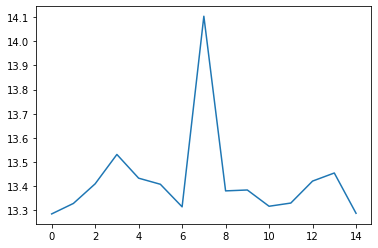

In [63]:
subset = {k: v for k, v in res1['smape'].items() if 'opt_adam__lr_0.001__ams_True__decay_True__1' in k}
r1 = [v for k, v in subset.items() if 'ens' not in k]
plt.plot(r1)

In [67]:
def evaluate_family_5(family, x, y, result_dict=None, desc=None, verbose=False):

    results = {'smape': {}, 'mase*': {}}
    results2 = {'smape': {}, 'mase*': {}} 
    results3 = {'smape': {}, 'mase*': {}} 

    family = Path(family)
    trials = list(family.parent.glob(family.name + '*'))  # list for tqdm

    family_preds = None
    trial_ind = 0

    if verbose:
        print('Run name:', family.name)
        print('Family path:', str(family))
        print('Trials identified:', len(trials))
        for i, t in enumerate(trials):
            print('  {:>2d}. {}'.format(i, t))

    ensemble_preds_all_trials = []

    for trial in trials:

        all_model_preds_in_trial = []

        trial = Path(trial)
        all_models_in_trial = list(trial.glob('*'))

        for epoch_ind, single_model in enumerate(all_models_in_trial):

            model = tf.keras.models.load_model(single_model)

            preds = evaluation.get_predictions(model, x)

#             if not family_preds:
#                 family_preds = [[] for _ in range(len(all_models_in_trial))]

#             family_preds[epoch_ind].append(preds)
            all_model_preds_in_trial.append(preds)

            tf.keras.backend.clear_session()

            results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
            results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

            ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

            results3['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
            results3['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))

            print('trial_ind', trial_ind)
            print('epoch_ind', epoch_ind)
#             print('len(family_preds[epoch_ind])', len(family_preds[epoch_ind]))
            print('len(all_model_preds_in_trial)', len(all_model_preds_in_trial))
            print('len(results[smape])', len(results['smape']))
            
        return results, results3
    
        trial_ind += 1

        ensemble_preds_all_trials.append(ensemble_preds)

    for i, epoch_preds in enumerate(family_preds):

        preds = np.median(np.array(epoch_preds), axis=0)

        results2['smape']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results2['mase*']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

    final_preds = np.median(np.array(ensemble_preds_all_trials), axis=0)

    results2['smape']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.SMAPE(y, final_preds[:, -6:]))
    results2['mase*']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.MASE(x, y, final_preds[:, -6:]))

    return results, results2, results3

In [68]:
res1, res3 = evaluate_family_5(family, X_test, y_test, verbose=True)

Run name: opt_adam__lr_0.001__ams_True__decay_True
Family path: ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True
Trials identified: 4
   0. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1
   1. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2
   2. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
   3. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3
trial_ind 0
epoch_ind 0
len(all_model_preds_in_trial) 1
len(results[smape]) 1
trial_ind 0
epoch_ind 1
len(all_model_preds_in_trial) 2
len(results[smape]) 2
trial_ind 0
epoch_ind 2
len(all_model_preds_in_trial) 3
len(results[smape]) 3
trial_ind 0
epoch_ind 3
len(all_model_preds_in_trial) 4
len(results[smape]) 4
trial_ind 0
epoch_ind 4
len(all_model_preds_in_trial) 5
len(results[smape]) 5
trial_ind 0
epoch_ind 5
len(all_model_preds_in_trial) 6
len(results[smape]) 6
trial_ind 0
epoch_ind 6
le

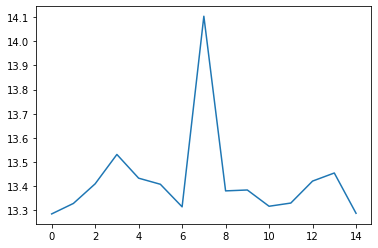

In [69]:
subset = {k: v for k, v in res1['smape'].items() if 'opt_adam__lr_0.001__ams_True__decay_True__1' in k}
r1 = [v for k, v in subset.items() if 'ens' not in k]
plt.plot(r1)

In [72]:
def evaluate_family_6(family, x, y, result_dict=None, desc=None, verbose=False):

    results = {'smape': {}, 'mase*': {}}

    family = Path(family)
    trials = list(family.parent.glob(family.name + '*'))

    trial = trials[0]
    print(trial)

    all_model_preds_in_trial = []

    trial = Path(trial)
    all_models_in_trial = list(trial.glob('*'))
    
    print(all_models_in_trial)

    for epoch_ind, single_model in enumerate(all_models_in_trial):

        model = tf.keras.models.load_model(single_model)

        preds = evaluation.get_predictions(model, x)

        all_model_preds_in_trial.append(preds)

        tf.keras.backend.clear_session()

        results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

        ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

        results['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
        results['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))

        print('epoch_ind', epoch_ind)
        print('len(all_model_preds_in_trial)', len(all_model_preds_in_trial))
        print('len(results[smape])', len(results['smape']))

    return results

In [73]:
ress = evaluate_family_6(family, X_test, y_test, verbose=True)

../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1
[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_005.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_012.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_011.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_002.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_001.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_013.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_006.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_000.h5'),

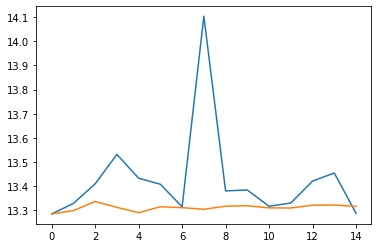

In [75]:
subset = {k: v for k, v in ress['smape'].items() if 'opt_adam__lr_0.001__ams_True__decay_True__1' in k}
r1 = [v for k, v in subset.items() if 'ens' not in k]
r2 = [v for k, v in subset.items() if 'ens' in k]
plt.plot(r1)
plt.plot(r2)

In [85]:
def evaluate_family_7(family, x, y, result_dict=None, desc=None, verbose=False):

    results = {'smape': {}, 'mase*': {}}

    fallback = []
    fallback_ens = []
    
    family = Path(family)
    trials = list(family.parent.glob(family.name + '*'))

    trial = trials[2]
    print(trial)

    all_model_preds_in_trial = []

    trial = Path(trial)
    all_models_in_trial = list(trial.glob('*'))
    
    print(all_models_in_trial)

    for epoch_ind, single_model in enumerate(all_models_in_trial):

        model = tf.keras.models.load_model(single_model)

        preds = evaluation.get_predictions(model, x)

        all_model_preds_in_trial.append(preds)

        tf.keras.backend.clear_session()

        s1 = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = s1
        results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))
        fallback.append(s1)
            
        ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

        s2 = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
        results['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = s2
        results['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))
        fallback_ens.append(s2)

        print('epoch_ind', epoch_ind)
        print('len(all_model_preds_in_trial)', len(all_model_preds_in_trial))
        print('len(results[smape])', len(results['smape']))

    return results, fallback, fallback_ens

In [86]:
ress, fb, fbe = evaluate_family_7(family, X_test, y_test, verbose=True)

../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_005.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_012.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_011.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_002.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_001.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_013.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_006.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_000.h5'),

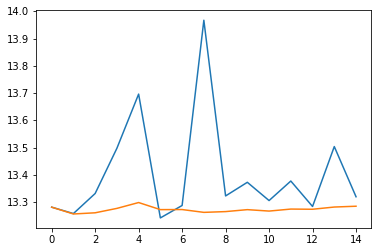

In [89]:
subset = {k: v for k, v in ress['smape'].items() if 'opt_adam__lr_0.001__ams_True__decay_True__0' in k}
r1 = [v for k, v in subset.items() if 'ens' not in k]
r2 = [v for k, v in subset.items() if 'ens' in k]
plt.plot(r1)
plt.plot(r2)

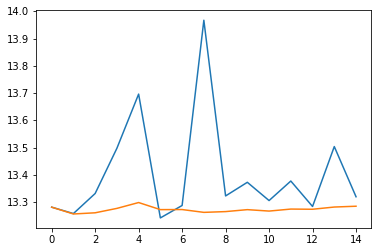

In [88]:
plt.plot(fb)
plt.plot(fbe)

In [91]:
def evaluate_family_8(family, x, y, result_dict=None, desc=None, verbose=False):

    results = {'smape': {}, 'mase*': {}}

    fallback = []
    fallback_ens = []
    
    family = Path(family)
    trials = list(family.parent.glob(family.name + '*'))

    trial = trials[2]
    print(trial)

    all_model_preds_in_trial = []

    trial = Path(trial)
    all_models_in_trial = list(trial.glob('*'))
    
    print(all_models_in_trial)

    for epoch_ind, single_model in enumerate(all_models_in_trial):

        model = tf.keras.models.load_model(single_model)

        preds = evaluation.get_predictions(model, x)
        return preds
        all_model_preds_in_trial.append(preds)

        tf.keras.backend.clear_session()

        s1 = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = s1
        results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))
        fallback.append(s1)
            
        ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

        s2 = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
        results['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = s2
        results['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))
        fallback_ens.append(s2)

        print('epoch_ind', epoch_ind)
        print('len(all_model_preds_in_trial)', len(all_model_preds_in_trial))
        print('len(results[smape])', len(results['smape']))

    return results, fallback, fallback_ens

In [92]:
p = evaluate_family_8(family, X_test, y_test)

../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_005.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_012.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_011.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_002.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_001.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_013.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_006.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_000.h5'),

In [99]:
sorted(list(Path(family).parent.glob(Path(family).name + '*')))

[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0'),
 PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1'),
 PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2'),
 PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3')]

In [100]:
!mkdir /tmp/test11

In [102]:
!mkdir /tmp/test11/1 /tmp/test11/2 /tmp/test11/3 /tmp/test11/4 /tmp/test11/5 /tmp/test11/6 /tmp/test11/7 /tmp/test11/8

In [103]:
!mkdir /tmp/test11/0 /tmp/test11/9 /tmp/test11/10 /tmp/test11/11 /tmp/test11/12

In [106]:
sorted(list(Path('/tmp/test11/').glob('*')))

[PosixPath('/tmp/test11/0'),
 PosixPath('/tmp/test11/1'),
 PosixPath('/tmp/test11/10'),
 PosixPath('/tmp/test11/11'),
 PosixPath('/tmp/test11/12'),
 PosixPath('/tmp/test11/2'),
 PosixPath('/tmp/test11/3'),
 PosixPath('/tmp/test11/4'),
 PosixPath('/tmp/test11/5'),
 PosixPath('/tmp/test11/6'),
 PosixPath('/tmp/test11/7'),
 PosixPath('/tmp/test11/8'),
 PosixPath('/tmp/test11/9')]

In [95]:
model_preds_2['../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_000.h5']

array([[ 7351.3633,  7431.8994,  7470.9727,  7542.619 ,  7618.61  ,
         7661.723 ],
       [ 1513.0276,  1564.1771,  1608.8691,  1654.0038,  1707.8842,
         1757.1377],
       [ 8431.716 ,  8657.25  ,  8841.766 ,  9064.315 ,  9278.399 ,
         9440.254 ],
       ...,
       [ 1153.5724,  1246.1045,  1286.2072,  1363.1514,  1441.3564,
         1483.7505],
       [ 7540.8496,  8214.973 ,  8815.082 ,  9456.734 , 10034.135 ,
        10511.1045],
       [ 8937.232 ,  9105.631 ,  9278.546 ,  9449.613 ,  9603.531 ,
         9746.676 ]], dtype=float32)

In [156]:
def evaluate_family_9(family, x, y, result_dict=None, desc=None, verbose=False):

    results = {'smape': {}, 'mase*': {}}

    fallback = []
    fallback_ens = []
    
    family = Path(family)
    trials = sorted(family.parent.glob(family.name + '*'), key=lambda x: int(x.name.split('__')[-1]))
    print(trials)
    trial = trials[0]
    print(trial)

    all_model_preds_in_trial = []

    trial = Path(trial)
    all_models_in_trial = sorted(trial.glob('*'), key=lambda x: x.name.split('/')[-1])
    
    print(all_models_in_trial)

    for epoch_ind, single_model in enumerate(all_models_in_trial):

        model = tf.keras.models.load_model(single_model)

        preds = evaluation.get_predictions(model, x)
        return preds
        all_model_preds_in_trial.append(preds)

        tf.keras.backend.clear_session()

        s1 = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = s1
        results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))
        fallback.append(s1)
            
        ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

        s2 = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
        results['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = s2
        results['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))
        fallback_ens.append(s2)

        print('epoch_ind', epoch_ind)
        print('len(all_model_preds_in_trial)', len(all_model_preds_in_trial))
        print('len(results[smape])', len(results['smape']))

    return results, fallback, fallback_ens

In [165]:
f = Path(family)
trials = sorted(f.parent.glob(f.name + '*'), key=lambda x: int(x.name.split('__')[-1]))


In [166]:
trials

[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0'),
 PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1'),
 PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2'),
 PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3')]

In [167]:
list(f.parent.glob(f.name + '*'))

[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1'),
 PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2'),
 PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0'),
 PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3')]

In [168]:
a = list(f.parent.glob(f.name + '*'))
a[0].name.split('__')[-1]

'1'

In [169]:
p = evaluate_family_9(family, X_test, y_test)

[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3')]
../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_000.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_001.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_002.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_003.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay

In [170]:
np.array_equal(p, model_preds_2['../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_000.h5'])

False

In [171]:
metrics.SMAPE(y_test, p[:, -6:]).mean()

13.966873516125027

In [172]:
metrics.SMAPE(y_test, model_preds_2['../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_000.h5'][:, -6:]).mean()

13.966872749073568

In [173]:
def evaluate_family_final(family, x, y, result_dict=None, desc=None, verbose=False):

    if not result_dict:
        results = {'smape': {}, 'mase*': {}}
        results2 = {'smape': {}, 'mase*': {}}
    else:
        results = result_dict.copy()

    family = Path(family)
    trials = sorted(family.parent.glob(family.name + '*'), key=lambda x: int(x.name.split('__')[-1]))

    family_preds = None
    trial_ind = 0

    if verbose:
        print('Run name:', family.name)
        print('Family path:', str(family))
        print('Trials identified:', len(trials))
        for i, t in enumerate(trials):
            print('  {:>2d}. {}'.format(i, t))

    ensemble_preds_all_trials = []

    for trial in tqdm(trials, desc=desc):

        all_model_preds_in_trial = []

        trial = Path(trial)
        all_models_in_trial = sorted(trial.glob('*'), key=lambda x: x.name.split('/')[-1])
        print(all_models_in_trial)

        for epoch_ind, single_model in enumerate(all_models_in_trial):

            model = tf.keras.models.load_model(single_model)

            preds = evaluation.get_predictions(model, x)

            if not family_preds:
                family_preds = [[] for _ in range(len(all_models_in_trial))]

            family_preds[epoch_ind].append(preds)
            all_model_preds_in_trial.append(preds)

            tf.keras.backend.clear_session()

            results['smape'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
            results['mase*'][trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

            ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

            results['smape']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y, ensemble_preds[:, -6:]))
            results['mase*']['ens__' + trial.name + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(x, y, ensemble_preds[:, -6:]))

        trial_ind += 1

        ensemble_preds_all_trials.append(ensemble_preds)

    for i, epoch_preds in enumerate(family_preds):

        preds = np.median(np.array(epoch_preds), axis=0)

        results2['smape']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.SMAPE(y, preds[:, -6:]))
        results2['mase*']['ens__' + family.name + '____epoch_{}'.format(i)] = np.nanmean(metrics.MASE(x, y, preds[:, -6:]))

    final_preds = np.median(np.array(ensemble_preds_all_trials), axis=0)

    results2['smape']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.SMAPE(y, final_preds[:, -6:]))
    results2['mase*']['ens__' + family.name + '____epoch_'] = np.nanmean(metrics.MASE(x, y, final_preds[:, -6:]))

    return results

In [ ]:
resf = evaluate_family_final(family, X_test, y_test, verbose=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Run name: opt_adam__lr_0.001__ams_True__decay_True
Family path: ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True
Trials identified: 4
   0. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0
   1. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1
   2. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2
   3. ../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3
[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_000.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_001.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_002.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__0/weights_epoch_003.h5'), PosixPath('../results/training_hy

 25%|██▌       | 1/4 [04:46<14:20, 286.91s/it]

[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_000.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_001.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_002.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_003.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_004.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_005.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_006.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__1/weights_epoch_007.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__de

 50%|█████     | 2/4 [10:39<10:13, 306.63s/it]

[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2/weights_epoch_000.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2/weights_epoch_001.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2/weights_epoch_002.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2/weights_epoch_003.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2/weights_epoch_004.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2/weights_epoch_005.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2/weights_epoch_006.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__2/weights_epoch_007.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__de

 75%|███████▌  | 3/4 [16:12<05:14, 314.44s/it]

[PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3/weights_epoch_000.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3/weights_epoch_001.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3/weights_epoch_002.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3/weights_epoch_003.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3/weights_epoch_004.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3/weights_epoch_005.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3/weights_epoch_006.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__decay_True__3/weights_epoch_007.h5'), PosixPath('../results/training_hyperparameters/opt_adam__lr_0.001__ams_True__de

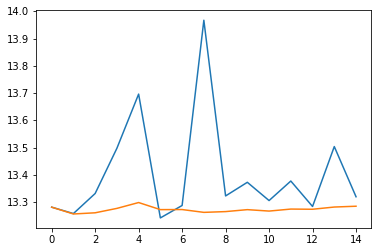

In [112]:
subset = {k: v for k, v in ress['smape'].items() if 'opt_adam__lr_0.001__ams_True__decay_True__0' in k}
r1 = [v for k, v in subset.items() if 'ens' not in k]
r2 = [v for k, v in subset.items() if 'ens' in k]
plt.plot(r1)
plt.plot(r2)

In [ ]:
def get_score(y_test, preds):
    return np.nanmean(metrics.SMAPE(y_test, preds[:, -6:])

all_model_preds_in_trial = []
results = {'smape': {}, 'mase*': {}}
epoch_ind = 0

for k, v in model_preds_2.items():

    preds = v

    all_model_preds_in_trial.append(preds)

    results['smape']['n' + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y_test, preds[:, -6:]))
    results['mase*']['n' + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(X_test, y_test, preds[:, -6:]))

    ensemble_preds = np.median(np.array(all_model_preds_in_trial), axis=0)

    results['smape']['ens__' + 'n' + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.SMAPE(y_test, ensemble_preds[:, -6:]))
    results['mase*']['ens__' + 'n' + '__epoch_{}'.format(epoch_ind + 1)] = np.nanmean(metrics.MASE(X_test, y_test, ensemble_preds[:, -6:]))

    epoch_ind += 1
    
    print(epoch_ind)